## Load data

In [297]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from scipy.stats import chi2_contingency, kruskal
import os
import networkx as nx
import warnings
warnings.filterwarnings("ignore")
import matplotlib.patches as mpatches

In [298]:
base_path = "../data/full"
algo = "w_slpa"
patient_df = pd.read_csv("../../data/thesis/cll_broad_2022_clinical_data_thesis.csv")
mutation_df = pd.read_csv("../../data/thesis/cll_broad_2022_mutations_thesis.csv")
community_df = pd.read_csv(os.path.join(base_path, algo, "community_assignments.csv"))

In [299]:
# Assign communityId to patient_df based on overlapping rules
from collections import defaultdict

# Build mapping: patientId -> list of communityIds
comm_map = defaultdict(list)
for _, row in community_df.iterrows():
    comm_map[row['patientId']].append(row['communityId'])

def resolve_community(comms):
    comms_set = set(comms)
    if {1,2}.issubset(comms_set):
        return 1
    elif {2,3}.issubset(comms_set):
        return 2
    else:
        return comms[0] if comms else np.nan

patient_df['communityId'] = patient_df['patientId'].map(lambda pid: resolve_community(comm_map.get(pid, [])))
patient_df['communityId'] = patient_df['communityId'].astype('Int64')  # Use Int64 for nullable integers
print(patient_df[['patientId', 'communityId']].head())
print(patient_df['communityId'].isna().sum())

    patientId  communityId
0  P-CRC-0001            0
1  P-CRC-0002            0
2  P-CRC-0003            0
3  P-CRC-0004            1
4  P-CRC-0005            1
135


In [300]:
columns = [
    'patientId', 
    'CLL_EPITYPE', 
    'MUTATION_COUNT', 
    'TUMOR_MOLECULAR_SUBTYPE',
    'AGE_SAMPLING', 
    'COHORT', 
    'IGHV_MUTATION_STATUS', 
    'SEX',
    'TREATMENT_AFTER_SAMPLING', 
    'communityId'
]
patient_df = patient_df[columns]
patient_df.head()
# patient_df.to_csv("patient_data_with_community.csv", index=False)

,patientId,CLL_EPITYPE,MUTATION_COUNT,TUMOR_MOLECULAR_SUBTYPE,AGE_SAMPLING,COHORT,IGHV_MUTATION_STATUS,SEX,TREATMENT_AFTER_SAMPLING,communityId
0,P-CRC-0001,n-CLL,26.0,U-CLL,46.0,UCSD,unmutated,Female,Chemo + Ab,0
1,P-CRC-0002,n-CLL,23.0,U-CLL,56.0,UCSD,unmutated,Male,Chemo + Ab,0
2,P-CRC-0003,n-CLL,7.0,U-CLL,63.0,UCSD,unmutated,Female,Chemo + Ab,0
3,P-CRC-0004,m-CLL,30.0,M-CLL,51.0,UCSD,mutated,Male,Chemo + Ab,1
4,P-CRC-0005,n-CLL,23.0,U-CLL,37.0,UCSD,unmutated,Male,Chemo + Ab,1


In [301]:
patient_df.isna().sum()

patientId                     0
CLL_EPITYPE                   0
MUTATION_COUNT              161
TUMOR_MOLECULAR_SUBTYPE     160
AGE_SAMPLING                  3
COHORT                        0
IGHV_MUTATION_STATUS         23
SEX                           3
TREATMENT_AFTER_SAMPLING    747
communityId                 135
dtype: int64

In [302]:
patient_df['communityId'].value_counts()

communityId
3    374
0    286
2    282
1     66
Name: count, dtype: Int64

## Mutations

In [303]:
top_mutations = {0: [{'hugoGeneSymbol': 'SF3B1', 'Percentage': np.float64(24.61)},
  {'hugoGeneSymbol': 'TP53', 'Percentage': np.float64(15.62)},
  {'hugoGeneSymbol': 'ATM', 'Percentage': np.float64(13.67)},
  {'hugoGeneSymbol': 'NOTCH1', 'Percentage': np.float64(8.98)},
  {'hugoGeneSymbol': 'TTN', 'Percentage': np.float64(8.98)},
  {'hugoGeneSymbol': 'XPO1', 'Percentage': np.float64(8.98)},
  {'hugoGeneSymbol': 'PCLO', 'Percentage': np.float64(8.2)},
  {'hugoGeneSymbol': 'BRAF', 'Percentage': np.float64(6.25)},
  {'hugoGeneSymbol': 'POT1', 'Percentage': np.float64(5.86)},
  {'hugoGeneSymbol': 'EGR2', 'Percentage': np.float64(5.86)}],
 1: [{'hugoGeneSymbol': 'SF3B1', 'Percentage': np.float64(22.22)},
  {'hugoGeneSymbol': 'TTN', 'Percentage': np.float64(9.52)},
  {'hugoGeneSymbol': 'ZMYM3', 'Percentage': np.float64(7.94)},
  {'hugoGeneSymbol': 'CSMD3', 'Percentage': np.float64(7.94)},
  {'hugoGeneSymbol': 'CSMD1', 'Percentage': np.float64(7.94)},
  {'hugoGeneSymbol': 'USH2A', 'Percentage': np.float64(7.94)},
  {'hugoGeneSymbol': 'FAT1', 'Percentage': np.float64(7.94)},
  {'hugoGeneSymbol': 'AHNAK', 'Percentage': np.float64(7.94)},
  {'hugoGeneSymbol': 'KRAS', 'Percentage': np.float64(7.94)},
  {'hugoGeneSymbol': 'MYD88', 'Percentage': np.float64(7.94)}],
 2: [{'hugoGeneSymbol': 'SF3B1', 'Percentage': np.float64(24.36)},
  {'hugoGeneSymbol': 'ATM', 'Percentage': np.float64(14.1)},
  {'hugoGeneSymbol': 'TP53', 'Percentage': np.float64(10.9)},
  {'hugoGeneSymbol': 'POT1', 'Percentage': np.float64(9.29)},
  {'hugoGeneSymbol': 'XPO1', 'Percentage': np.float64(6.09)},
  {'hugoGeneSymbol': 'LRP1B', 'Percentage': np.float64(5.77)},
  {'hugoGeneSymbol': 'TTN', 'Percentage': np.float64(5.45)},
  {'hugoGeneSymbol': 'ZFHX4', 'Percentage': np.float64(5.13)},
  {'hugoGeneSymbol': 'KRAS', 'Percentage': np.float64(5.13)},
  {'hugoGeneSymbol': 'NOTCH1', 'Percentage': np.float64(5.13)}],
 3: [{'hugoGeneSymbol': 'SF3B1', 'Percentage': np.float64(8.72)},
  {'hugoGeneSymbol': 'TTN', 'Percentage': np.float64(7.85)},
  {'hugoGeneSymbol': 'ATM', 'Percentage': np.float64(7.85)},
  {'hugoGeneSymbol': 'CHD2', 'Percentage': np.float64(6.69)},
  {'hugoGeneSymbol': 'PCLO', 'Percentage': np.float64(5.81)},
  {'hugoGeneSymbol': 'CSMD3', 'Percentage': np.float64(5.81)},
  {'hugoGeneSymbol': 'MUC16', 'Percentage': np.float64(5.52)},
  {'hugoGeneSymbol': 'KLHL6', 'Percentage': np.float64(5.52)},
  {'hugoGeneSymbol': 'MYD88', 'Percentage': np.float64(5.23)},
  {'hugoGeneSymbol': 'LRP1B', 'Percentage': np.float64(4.65)}]}


top_mutations_set = set()
for i in top_mutations.keys():
    for val in top_mutations[i]:
        top_mutations_set.add(val['hugoGeneSymbol'])
    
print(top_mutations_set)

{'TTN', 'CSMD1', 'PCLO', 'CSMD3', 'KRAS', 'FAT1', 'EGR2', 'BRAF', 'ATM', 'SF3B1', 'MYD88', 'CHD2', 'POT1', 'MUC16', 'ZMYM3', 'AHNAK', 'ZFHX4', 'TP53', 'LRP1B', 'KLHL6', 'XPO1', 'USH2A', 'NOTCH1'}


In [304]:
# Assuming patient_df and mutation_df are already loaded
# Create a pivot table or boolean matrix for mutations
mutation_df['has_mutation'] = True
mutation_pivot = mutation_df[mutation_df['hugoGeneSymbol'].isin(top_mutations_set)].pivot_table(
    index='patientId',
    columns='hugoGeneSymbol',
    values='has_mutation',
    fill_value=0.0
)

# Ensure all top mutations are present as columns
for gene in top_mutations_set:
    if gene not in mutation_pivot.columns:
        mutation_pivot[gene] = 0.0

# Reorder columns to match top_mutations_set
mutation_pivot = mutation_pivot[list(top_mutations_set)]

# Merge with patient_df
patient_df = patient_df.merge(mutation_pivot, how='left', left_on='patientId', right_index=True)

# Fill NaN values with False for patients with no mutations
patient_df[list(top_mutations_set)] = patient_df[list(top_mutations_set)].fillna(0.0)

# # Replace 1.0 with 'yes' and 0.0 with 'no' for all mutation columns
# for gene in top_mutations_set:
#     patient_df[gene] = patient_df[gene].replace({1.0: 'yes', 0.0: 'no'})

# Display the updated DataFrame
display(patient_df.head())
print(patient_df.shape)
print(patient_df.columns)

,patientId,CLL_EPITYPE,MUTATION_COUNT,TUMOR_MOLECULAR_SUBTYPE,AGE_SAMPLING,COHORT,IGHV_MUTATION_STATUS,SEX,TREATMENT_AFTER_SAMPLING,communityId,...,MUC16,ZMYM3,AHNAK,ZFHX4,TP53,LRP1B,KLHL6,XPO1,USH2A,NOTCH1
0,P-CRC-0001,n-CLL,26.0,U-CLL,46.0,UCSD,unmutated,Female,Chemo + Ab,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,P-CRC-0002,n-CLL,23.0,U-CLL,56.0,UCSD,unmutated,Male,Chemo + Ab,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,P-CRC-0003,n-CLL,7.0,U-CLL,63.0,UCSD,unmutated,Female,Chemo + Ab,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,P-CRC-0004,m-CLL,30.0,M-CLL,51.0,UCSD,mutated,Male,Chemo + Ab,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,P-CRC-0005,n-CLL,23.0,U-CLL,37.0,UCSD,unmutated,Male,Chemo + Ab,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


(1143, 33)
Index(['patientId', 'CLL_EPITYPE', 'MUTATION_COUNT', 'TUMOR_MOLECULAR_SUBTYPE',
       'AGE_SAMPLING', 'COHORT', 'IGHV_MUTATION_STATUS', 'SEX',
       'TREATMENT_AFTER_SAMPLING', 'communityId', 'TTN', 'CSMD1', 'PCLO',
       'CSMD3', 'KRAS', 'FAT1', 'EGR2', 'BRAF', 'ATM', 'SF3B1', 'MYD88',
       'CHD2', 'POT1', 'MUC16', 'ZMYM3', 'AHNAK', 'ZFHX4', 'TP53', 'LRP1B',
       'KLHL6', 'XPO1', 'USH2A', 'NOTCH1'],
      dtype='object')


In [305]:
patient_df.isna().sum()

patientId                     0
CLL_EPITYPE                   0
MUTATION_COUNT              161
TUMOR_MOLECULAR_SUBTYPE     160
AGE_SAMPLING                  3
COHORT                        0
IGHV_MUTATION_STATUS         23
SEX                           3
TREATMENT_AFTER_SAMPLING    747
communityId                 135
TTN                           0
CSMD1                         0
PCLO                          0
CSMD3                         0
KRAS                          0
FAT1                          0
EGR2                          0
BRAF                          0
ATM                           0
SF3B1                         0
MYD88                         0
CHD2                          0
POT1                          0
MUC16                         0
ZMYM3                         0
AHNAK                         0
ZFHX4                         0
TP53                          0
LRP1B                         0
KLHL6                         0
XPO1                          0
USH2A   

## Decision Tree

Number of rows after dropping missing target: 1008
Feature matrix shape: (1008, 16), Target vector shape: (1008,)


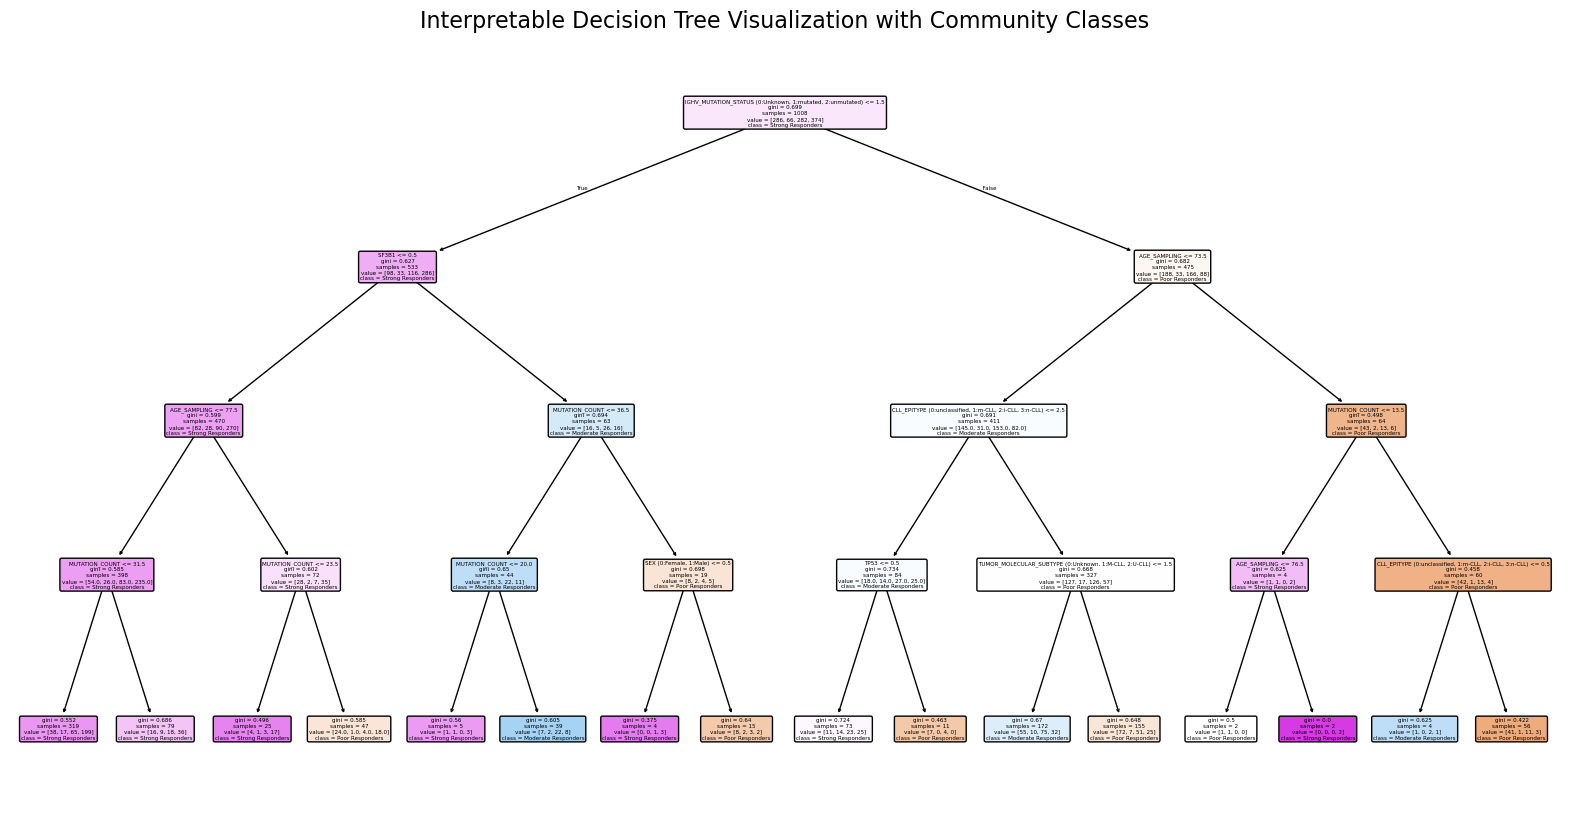

Decision tree trained and visualized.


In [306]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the dataset
df = patient_df.copy(deep=True)

# Select relevant columns
features = ['AGE_SAMPLING', 'IGHV_MUTATION_STATUS', 'CLL_EPITYPE', 
            'TUMOR_MOLECULAR_SUBTYPE', 'MUTATION_COUNT', 'SEX',
            'SF3B1', 'TP53', 'POT1', 'CSMD1', 'ZMYM3', 'PCLO',  'MYD88', 'NOTCH1',  'ATM', 'TTN',
            ]
target = 'communityId'

# Drop rows with missing target
df = df.dropna(subset=[target])
print(f"Number of rows after dropping missing target: {len(df)}")

#Specify the desired order for each categorical variable
category_orders = {
    'IGHV_MUTATION_STATUS': ['Unknown', 'mutated', 'unmutated'],
    'CLL_EPITYPE': ['unclassified', 'm-CLL', 'i-CLL', 'n-CLL'],
    'TUMOR_MOLECULAR_SUBTYPE': ['Unknown', 'M-CLL', 'U-CLL'],
    'SEX': ['Female', 'Male']
}

# for col in ['SF3B1', 'TP53', 'POT1', 'CSMD1', 'ZMYM3', 'PCLO',  'MYD88', 'NOTCH1',  'ATM', 'TTN',
#             ]:
#     category_orders[col] = ['yes', 'no']

# Fill missing values for categorical columns with 'Unknown'
for col, order in category_orders.items():
    df[col] = df[col].fillna('Unknown')

# Fill missing values for numerical columns
for col in features:
    if col not in category_orders and df[col].dtype in [np.float64, np.int64]:
        df[col] = df[col].fillna(df[col].median())

# Ordinal encode categorical columns
ordinal_encoder = OrdinalEncoder(categories=[category_orders[col] for col in category_orders])
cat_features = list(category_orders.keys())
df[cat_features] = ordinal_encoder.fit_transform(df[cat_features])


X = df[features]
y = df[target].astype(int)
print(f"Feature matrix shape: {X.shape}, Target vector shape: {y.shape}")

# Store mapping for decoding
decode_maps = {col: category_orders[col] for col in cat_features}

class_map = {
    0: "Poor Responders",
    1: "Early Failure, Long Term Survival",
    2: "Moderate Responders",
    3: "Strong Responders"
}
# map the int to the class names
decode_maps[target] = [class_map[i] for i in sorted(class_map.keys())]

# Function to decode encoded values back to labels
def decode_feature(col, val):
    order = decode_maps[col]
    idx = int(val)
    if 0 <= idx < len(order):
        return order[idx]
    return "Unknown"

# Train decision tree
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X, y)

# Prepare display names for features for plot_tree
display_feature_names = []
for col in features:
    if col in decode_maps:
        display_feature_names.append(f"{col} (0:{decode_maps[col][0]}, 1:{decode_maps[col][1]}, 2:{decode_maps[col][2]})" if len(decode_maps[col])==3 else f"{col} ({', '.join([f'{i}:{v}' for i,v in enumerate(decode_maps[col])])})")
    else:
        display_feature_names.append(col)

# Visualize the decision tree with actual labels in feature names
plt.figure(figsize=(20, 10))
plot_tree(
    clf,
    feature_names=display_feature_names,
    class_names=[class_map[i] for i in sorted(y.unique())],
    filled=True,
    fontsize=4,
    rounded=True,
)

plt.title("Interpretable Decision Tree Visualization with Community Classes", fontsize=16)

plt.savefig("../../figures/decision_tree.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Extract simplified decision rules
tree_rules = export_text(clf, feature_names=features)

print("Decision tree trained and visualized.")

# print("Rules extracted and saved to 'decision_tree_rules.txt'.")
# # Save rules to a text file
# with open("decision_tree_rules.txt", "w") as f:
#     f.write(tree_rules)

In [307]:
# use cross validation to get the best max depth
from sklearn.model_selection import cross_val_score
depths = range(3, 11)
cv_scores = []
for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# use the best depth
best_depth = depths[np.argmax(cv_scores)]
print(f"Best max depth: {best_depth}") 
print(f"Best score: {max(cv_scores):.2f}") 

Best max depth: 5
Best score: 0.45


In [308]:
# Train-test split and evaluation with depth=4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Metrics
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Test Precision: {precision_score(y_test, y_pred, average='weighted', zero_division=0):.2f}")
print(f"Test Recall: {recall_score(y_test, y_pred, average='weighted', zero_division=0):.2f}")
print(f"Test F1 Score: {f1_score(y_test, y_pred, average='weighted', zero_division=0):.2f}")


Test Accuracy: 0.44
Test Precision: 0.40
Test Recall: 0.44
Test F1 Score: 0.40


## Association Rule Mining

<Axes: >

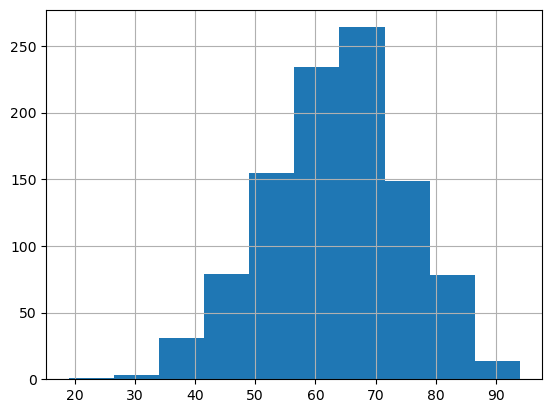

In [309]:
df['AGE_SAMPLING'].hist()

<Axes: >

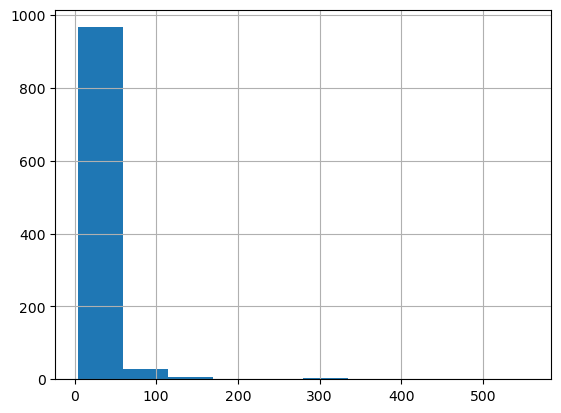

In [310]:
df['MUTATION_COUNT'].hist()

In [311]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Assume patient_df is already loaded
dfdf = patient_df.copy(deep=True)

dfdf = dfdf.dropna(subset=['communityId'])
# Convert communityId to string
dfdf['communityId'] = dfdf['communityId'].astype(str)
# dfdf = dfdf[dfdf['communityId'] != '3']

# Step 1: Replace missing values with 'Unknown' for categorical columns
categorical_cols = [
    'IGHV_MUTATION_STATUS', 
    'CLL_EPITYPE', 
    'TUMOR_MOLECULAR_SUBTYPE', 
    'SEX', 
    'TREATMENT_AFTER_SAMPLING',
    'communityId',
    # 'SF3B1',
    # 'TP53',
    #                 'POT1', 'CSMD1', 'ZMYM3', 'PCLO',  'MYD88', 'NOTCH1',  'ATM', 'TTN',
    #                 'KRAS', 'BRAF', 'CHD2', 'XPO1', 'ZFHX4', 'EGR2', 'USH2A', 'FAT1', 'KLHL6', 'AHNAK', 'LRP1B', 'CSMD3', 'MUC16'
                
    'SF3B1',
    'TP53',
    'PCLO',  
    'NOTCH1',  
    'ATM',
    'ZFHX4',
    'FAT1', 
    'KLHL6'         
    ]
for col in categorical_cols:
    dfdf[col] = dfdf[col].fillna('Unknown')

# Remove 'unclassified' from CLL_EPITYPE if needed
dfdf['CLL_EPITYPE'] = dfdf['CLL_EPITYPE'].replace('unclassified', 'Unknown')

# Step 2: Bin numerical features with 'Unknown' for missing values
def bin_age(age):
    if pd.isna(age):
        return 'Unknown'
    elif age <= 60:
        return 'Young'
    elif age <= 70:
        return 'Middle'
    else:
        return 'Old'
    #[0, 60, 64, 70, 120]
    # elif age <= 60:
    #     return 'Young'  
    # elif age <= 64:
    #     return 'Middle'
    # elif age <= 70:
    #     return 'Old'
    # else:
    #     return 'Very Old'

def bin_mutation_count(count):
    if pd.isna(count):
        return 'Unknown'
    elif count <= 20:
        return 'Low'
    elif count <= 30:
        return 'Medium'
    else:
        return 'High'
    # [0, 23, 25, 30, 500]
    # elif count <= 23:
    #     return 'Low'
    # elif count <= 25:
    #     return 'Medium'
    # elif count <= 30:
    #     return 'High'
    # else:
    #     return 'Very High'

dfdf['AGE_BIN'] = dfdf['AGE_SAMPLING'].apply(bin_age)
dfdf['MUTATION_BIN'] = dfdf['MUTATION_COUNT'].apply(bin_mutation_count)

# Step 3: Encode categorical variables into transaction format
transactions = dfdf[
    ['AGE_BIN', 'MUTATION_BIN'] + 
    categorical_cols
    ]
og_transactions = transactions.copy(deep=True)

# Convert to one-hot encoding
encoded_df = pd.get_dummies(transactions)

# Step 4: Apply Apriori algorithm
frequent_itemsets = apriori(encoded_df, min_support=0.01, use_colnames=True)
print(f"Number of frequent itemsets: {len(frequent_itemsets)}")

# Step 5: Generate association rules with communityId as consequent
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.65)
rules = rules[rules['consequents'].apply(lambda x: any('communityId_' in item for item in x))]

# in rules, can support to converted to #records instead of percentage
# Convert support from percentage to number of records
rules['support'] = rules['support'] * len(dfdf)

# Step 6: Sort and display top rules
top_rules = rules.sort_values(by=[ 'support',  'confidence', 'lift'], ascending=False)
display(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(50))

# top_rules[['antecedents', 'consequents', 'support', 'confidence']].to_csv("./rules.csv")

Number of frequent itemsets: 6853


,antecedents,consequents,support,confidence,lift
509,"(TREATMENT_AFTER_SAMPLING_Unknown, IGHV_MUTATI...",(communityId_3),255.0,0.683646,1.842554
594,"(TREATMENT_AFTER_SAMPLING_Unknown, CLL_EPITYPE...",(communityId_3),181.0,0.724000,1.951316
2623,"(TREATMENT_AFTER_SAMPLING_Unknown, IGHV_MUTATI...",(communityId_3),177.0,0.719512,1.939220
2627,"(TREATMENT_AFTER_SAMPLING_Unknown, CLL_EPITYPE...","(IGHV_MUTATION_STATUS_mutated, communityId_3)",177.0,0.708000,2.539730
2666,"(TREATMENT_AFTER_SAMPLING_Unknown, IGHV_MUTATI...",(communityId_3),116.0,0.763158,2.056853
2640,"(TREATMENT_AFTER_SAMPLING_Unknown, IGHV_MUTATI...",(communityId_3),111.0,0.702532,1.893454
2887,"(TREATMENT_AFTER_SAMPLING_Unknown, CLL_EPITYPE...",(communityId_3),102.0,0.703448,1.895925
6193,"(TREATMENT_AFTER_SAMPLING_Unknown, IGHV_MUTATI...",(communityId_3),99.0,0.697183,1.879039
6197,"(TREATMENT_AFTER_SAMPLING_Unknown, CLL_EPITYPE...","(IGHV_MUTATION_STATUS_mutated, communityId_3)",99.0,0.682759,2.449184
384,"(IGHV_MUTATION_STATUS_mutated, MUTATION_BIN_Low)",(communityId_3),99.0,0.664430,1.790762


In [312]:
import os

def save_rules(rules, index):
    # Keep only rules where the consequent is exactly {'communityId_X'}
    target_consequent = {f'communityId_{index}'}
    top_rules = rules[rules['consequents'].apply(lambda x: x == target_consequent)]
    print(f"Number of rules for community {index}: {len(top_rules)}")
    if top_rules.empty:
        return

    # Remove rules with 'Unknown' in antecedents or consequents
    def has_unknown(itemset):
        return any('Unknown' in item for item in itemset)

    top_rules = top_rules[~top_rules['antecedents'].apply(has_unknown)]
    top_rules = top_rules[~top_rules['consequents'].apply(has_unknown)]

    print(f"Number of rules after removing 'Unknown': {len(top_rules)}")
    if top_rules.empty:
        return

    # Initialize redundancy flags
    is_redundant = [False] * len(top_rules)
    subset_ids = [None] * len(top_rules)

    antecedents_list = top_rules['antecedents'].tolist()

    for i, ant_i in enumerate(antecedents_list):
        for j, ant_j in enumerate(antecedents_list):
            if i != j and ant_j.issubset(ant_i):
                is_redundant[i] = True
                subset_ids[i] = top_rules.index[j]
                break

    # Add redundancy information to DataFrame
    top_rules = top_rules.copy()
    top_rules['isRedundant'] = is_redundant
    top_rules['subsetId'] = subset_ids

    # top_rules = top_rules[top_rules['isRedundant'] == False]

    # Sort by support, confidence and lift
    top_rules = top_rules.sort_values(by=['support', 'confidence', 'lift'], ascending=False)

    # Display top rules
    display(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'isRedundant', 'subsetId']].head(30))

    # Save to CSV
    top_rules_path = "../data/rules/"
    os.makedirs(top_rules_path, exist_ok=True)
    top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'isRedundant', 'subsetId']].to_csv(
        f"{top_rules_path}/rules_{index}.csv"
    )



In [313]:
for i in range(4):
    save_rules(rules, i)

Number of rules for community 0: 46
Number of rules after removing 'Unknown': 41


,antecedents,consequents,support,confidence,lift,isRedundant,subsetId
1711,"(IGHV_MUTATION_STATUS_unmutated, AGE_BIN_Old, ...",(communityId_0),25.0,0.657895,2.318734,False,NaN
1720,"(TREATMENT_AFTER_SAMPLING_Chemo + no Ab, AGE_B...",(communityId_0),24.0,0.727273,2.563255,False,NaN
2088,"(IGHV_MUTATION_STATUS_unmutated, TREATMENT_AFT...",(communityId_0),21.0,0.777778,2.741259,False,NaN
4677,"(IGHV_MUTATION_STATUS_unmutated, AGE_BIN_Old, ...",(communityId_0),20.0,0.800000,2.819580,True,1720.0
1743,"(TREATMENT_AFTER_SAMPLING_Chemo + no Ab, AGE_B...",(communityId_0),20.0,0.769231,2.711135,False,NaN
1760,"(TREATMENT_AFTER_SAMPLING_Chemo + no Ab, AGE_B...",(communityId_0),20.0,0.666667,2.349650,False,NaN
2108,"(TREATMENT_AFTER_SAMPLING_Chemo + no Ab, CLL_E...",(communityId_0),19.0,0.826087,2.911523,False,NaN
5436,"(IGHV_MUTATION_STATUS_unmutated, TREATMENT_AFT...",(communityId_0),19.0,0.826087,2.911523,True,2088.0
1750,"(TREATMENT_AFTER_SAMPLING_Chemo + no Ab, AGE_B...",(communityId_0),19.0,0.655172,2.309139,False,NaN
4653,"(IGHV_MUTATION_STATUS_unmutated, AGE_BIN_Old, ...",(communityId_0),17.0,0.708333,2.496503,True,1711.0


Number of rules for community 1: 0
Number of rules for community 2: 3
Number of rules after removing 'Unknown': 1


,antecedents,consequents,support,confidence,lift,isRedundant,subsetId
47,(TREATMENT_AFTER_SAMPLING_BTK inhibitor),(communityId_2),13.0,0.764706,2.733417,False,None


Number of rules for community 3: 376
Number of rules after removing 'Unknown': 80


,antecedents,consequents,support,confidence,lift,isRedundant,subsetId
384,"(IGHV_MUTATION_STATUS_mutated, MUTATION_BIN_Low)",(communityId_3),99.0,0.664430,1.790762,False,NaN
397,"(CLL_EPITYPE_m-CLL, MUTATION_BIN_Low)",(communityId_3),68.0,0.686869,1.851240,False,NaN
2154,"(IGHV_MUTATION_STATUS_mutated, MUTATION_BIN_Lo...",(communityId_3),66.0,0.680412,1.833839,True,384.0
2171,"(IGHV_MUTATION_STATUS_mutated, MUTATION_BIN_Lo...",(communityId_3),63.0,0.677419,1.825772,True,384.0
2159,"(IGHV_MUTATION_STATUS_mutated, MUTATION_BIN_Lo...",(communityId_3),46.0,0.676471,1.823215,True,384.0
1783,"(IGHV_MUTATION_STATUS_mutated, AGE_BIN_Young, ...",(communityId_3),44.0,0.733333,1.976471,True,384.0
2248,"(SEX_Male, CLL_EPITYPE_m-CLL, MUTATION_BIN_Low)",(communityId_3),42.0,0.688525,1.855703,True,397.0
5552,"(IGHV_MUTATION_STATUS_mutated, MUTATION_BIN_Lo...",(communityId_3),40.0,0.677966,1.827246,True,384.0
1530,"(AGE_BIN_Middle, CLL_EPITYPE_m-CLL, SEX_Female)",(communityId_3),32.0,0.711111,1.916578,False,NaN
4092,"(IGHV_MUTATION_STATUS_mutated, AGE_BIN_Middle,...",(communityId_3),32.0,0.711111,1.916578,True,1530.0


In [314]:
# community_0 [1659, 2291, 755, 2214]; these [3903, 3275] are optional
# community_3 [290, 3289, 4066, 3305]; these [5352, 5256] are optional


In [315]:
og_transactions[og_transactions['communityId']=='0']['TREATMENT_AFTER_SAMPLING'].value_counts()

TREATMENT_AFTER_SAMPLING
Unknown              152
Chemo + Ab            65
Chemo + no Ab         51
Ab + no chemo          9
PI3K inhibitor         2
SRC inhibitor          1
BCL2 + chemo           1
PI3K + chemo + Ab      1
LEN + chemo + Ab       1
BTK inhibitor          1
BCL2 inhibitor         1
SYK inhibitor          1
Name: count, dtype: int64

In [316]:
def get_rule_metrics(patient_df, feature_dict, community_id):
    """
    Calculate support and confidence for a rule:
    IF feature_dict THEN communityId == community_id

    Parameters:
    - patient_df: DataFrame containing patient data
    - feature_dict: dict of feature-value pairs (antecedent)
    - community_id: str or int representing the community (consequent)

    Returns:
    - support: proportion of all rows matching both antecedent and consequent
    - confidence: proportion of antecedent-matching rows that also match the consequent
    """
    # Ensure communityId is string for consistency
    df = patient_df.copy()
    df['communityId'] = df['communityId'].astype(str)
    community_id = str(community_id)

    # Build mask for antecedent
    antecedent_mask = pd.Series(True, index=df.index)
    for col, val in feature_dict.items():
        antecedent_mask &= (df[col] == val)

    # Build mask for consequent
    consequent_mask = df['communityId'] == community_id

    # Calculate support and confidence
    total_rows = len(df)
    antecedent_rows = df[antecedent_mask]
    both_mask = antecedent_mask & consequent_mask
    both_rows = df[both_mask]

    support = len(both_rows)
    confidence = len(both_rows) / len(antecedent_rows) if len(antecedent_rows) > 0 else 0

    return support, confidence


In [317]:
feature_dict = {
    # 'AGE_BIN': 'Old',
    # 'IGHV_MUTATION_STATUS': 'unmutated',
    # 'CLL_EPITYPE':'n-CLL',
    # 'TUMOR_MOLECULAR_SUBTYPE': 'M-CLL',
    # 'SEX': 'Male'
    # 'MUTATION_BIN': 'High',
    # 'SF3B1': 1.0,
    # 'TP53': 1.0,
    # 'NOTCH1': 1.0,
    # 'ATM': 1.0,
    # 'KLHL6': 1.0,
    # 'ZFHX4': 1.0,
}
community_id = '0'

support, confidence = get_rule_metrics(og_transactions, feature_dict, community_id)
print(f"Support: {support:.4f}, Confidence: {confidence:.4f}")


# 'CLL_EPITYPE':'n-CLL',
# 'TUMOR_MOLECULAR_SUBTYPE': 'U-CLL',
# 'SF3B1': 1.0,
# this has 61.3 confidence


Support: 286.0000, Confidence: 0.2837


In [318]:
og_transactions[
    # (og_transactions['SF3B1'] == 1.0) & 
    # (og_transactions['TUMOR_MOLECULAR_SUBTYPE'] == 'U-CLL')  &
    # (og_transactions['CLL_EPITYPE'] == 'n-CLL') &
    # (og_transactions['AGE_BIN'] == 'Young') &
    # (og_transactions['MUTATION_BIN'] == 'Medium')
    (og_transactions['KLHL6'] == 1.0)

# ].value_counts()
]['communityId'].value_counts()

# (og_transactions['communityId'] == '0') & 

communityId
3    19
0     3
2     2
Name: count, dtype: int64

## Categorical Features - NMI/ARI Quality Metrics Table

In [319]:
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

# Load the dataset
df = patient_df.copy(deep=True)

# Define the features to compare with communityId
features = [
    'IGHV_MUTATION_STATUS',
    'CLL_EPITYPE',
    'TUMOR_MOLECULAR_SUBTYPE',
    'COHORT',
    'SEX',
]

# Drop rows with missing communityId
df = df.dropna(subset=['communityId'])

# age bin using above function bin_age
df['AGE_BIN'] = df['AGE_SAMPLING'].apply(lambda x: bin_age(x))

# [0, 23, 25, 30, 500] use these bins for mutation count
def bin_mutation_count(count):
    if pd.isna(count):
        return 'Unknown'
    elif count <= 23:
        return 'Low'
    elif count <= 25:
        return 'Medium'
    elif count <= 30:
        return 'High'
    else:
        return 'Very High'
df['MUT_BIN'] = df['MUTATION_COUNT'].apply(lambda x: bin_mutation_count(x))

# Add age and mutation count bins to features
features += ['AGE_BIN', 'MUT_BIN']

# Initialize results dictionary
results = {'Feature': [], 'NMI': [], 'ARI': []}

# Compute NMI and ARI for each feature
for feature in features:
    # Drop rows with missing values in the feature
    valid_rows = df[[feature, 'communityId']].dropna()
    x = valid_rows[feature]
    y = valid_rows['communityId'].astype(int)

    # Encode categorical features
    if x.dtype == 'object':
        x = pd.factorize(x)[0]

    # Compute metrics
    nmi = normalized_mutual_info_score(y, x)
    ari = adjusted_rand_score(y, x)

    # Store results
    results['Feature'].append(feature)
    results['NMI'].append(round(nmi, 4))
    results['ARI'].append(round(ari, 4))

# Create DataFrame
metrics_df = pd.DataFrame(results)
metrics_df.set_index('Feature', inplace=True)

# Save to CSV
# metrics_df.to_csv("nmi_ari_metrics.csv")

# Generate LaTeX table
latex_table = metrics_df.to_latex(index=True, float_format="%.4f", column_format="|l|c|c|")

# Save LaTeX table to file
# with open("nmi_ari_metrics_table.tex", "w") as f:
#     f.write(latex_table)

metrics_df


,NMI,ARI
Feature,,
IGHV_MUTATION_STATUS,0.0761,0.0974
CLL_EPITYPE,0.0677,0.0821
TUMOR_MOLECULAR_SUBTYPE,0.0064,0.0006
COHORT,0.0764,0.0449
SEX,0.0070,0.0019
AGE_BIN,0.0136,0.0071
MUT_BIN,0.0166,0.0187
